In [1]:
import sys
print(sys.version)

3.7.2 (default, Dec 29 2018, 06:19:36) 
[GCC 7.3.0]


In [2]:
! eups list -s | grep pfs_pipe2d

pfs_pipe2d            w.2022.19  	current setup


In [27]:
"""
Created on May 03 2022
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/tigress/ncaplar/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)

In [30]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


%load_ext autoreload
%autoreload 2

import Zernike_Module
import Zernike_Analysis_Module
from Zernike_Module import *
from Residual_1D_module import * 
from Zernike_Analysis_Module import *

# 0.35d or greater

print('Zernike_Module.__version__: '+str(Zernike_Module.__version__))
print('Zernike_Analysis_Module.__version__: '+str(Zernike_Analysis_Module.__version__))


import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math
import pickle
import glob
import time

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
import lsst.afw
from lsst.afw.cameraGeom import PupilFactory
from lsst.afw.geom import Angle, degrees
from lsst.afw import geom
from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
#import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
matplotlib.rcParams["figure.facecolor"] = "white"

from shutil import copy
from scipy.optimize import curve_fit

from astropy.io import fits

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c



print(np.__version__)
#print(skimage.__version__)
print(scipy.__version__)
print(pd.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Zernike_Module.__version__: 0.51f
Zernike_Analysis_Module.__version__: 0.26l
1.16.2
1.5.2
0.24.2


# April 18

In [31]:
import glob

#finalAr_wrong_secondary=np.load("/tigress/ncaplar/ReducedData/Data_May_21_2021/Dataframes/finalAr_Jul2021_wrong_secondary",allow_pickle=True)
finalAr=np.load("/tigress/ncaplar/ReducedData/Data_May_25_2021/Dataframes/finalAr_Jul2021",allow_pickle=True)
finalNe=np.load("/tigress/ncaplar/ReducedData/Data_May_25_2021/Dataframes/finalNe_Jul2021",allow_pickle=True)
finalKr=np.load("/tigress/ncaplar/ReducedData/Data_May_25_2021/Dataframes/finalKr_Jul2021",allow_pickle=True)

def remove(string): 
    return string.replace(" ", "")

pd.reset_option("display.max_rows")
import pickle
DATAFRAMES_FOLDER='/tigress/ncaplar/PFS/Fit_Results/Sep0521/'
if not os.path.exists(DATAFRAMES_FOLDER):
    os.makedirs(DATAFRAMES_FOLDER )
    
results_of_fit_many_Ar_Sep0521=np.load(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Ar_from_Sep0521.pkl',allow_pickle=True)
results_of_fit_many_Ne_Sep0521=np.load(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Ne_from_Sep0521.pkl',allow_pickle=True)
results_of_fit_many_Kr_Sep0521=np.load(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Kr_from_Sep0521.pkl',allow_pickle=True)

## single image analysis 

In [32]:
date_folder=''
date_files='Apr1822'
ResultsFromTiger_FOLDER='/tigress/ncaplar/Results/'


#Emcee3_HgAr=glob.glob(ResultsFromTiger_FOLDER+date+'/chain'+date+'_Single_P_*HgArSwarm1.npy', recursive=True)

Emcee3_Ar=glob.glob(ResultsFromTiger_FOLDER+date_folder+'/chain'+date_files+'_Single_P_*ArSwarm1.npy', recursive=True)
Emcee3_Ne=glob.glob(ResultsFromTiger_FOLDER+date_folder+'/chain'+date_files+'_Single_P_*NeSwarm1.npy', recursive=True)
Emcee3_Kr=glob.glob(ResultsFromTiger_FOLDER+date_folder+'/chain'+date_files+'_Single_P_*KrSwarm1.npy', recursive=True)

In [33]:
date='Sep0521'

single_number='11'
image_index=int(single_number)
eps=8
arc='Ar'


if arc=='Ar':

    finalArc=finalAr
    if int(single_number)<120:
        dataset=6
        obs=34341+96
    if int(single_number)>=120:
        dataset=8
        obs=51485+16*12
        
if arc=='Ne':

    finalArc=finalNe
    if int(single_number)<90:
        dataset=6
        obs=27719
    if int(single_number)>=90:
        dataset=8    
        obs=59655+16*12
        
        
if arc=='Kr':

    finalArc=finalKr
    if int(single_number)<40:
        dataset=6
        obs=34561+96
    if int(single_number)>=40:
        dataset=8
        obs=52085+16*12
    

wavelength=float(finalArc.loc[int(single_number)]['wavelength'])
#wavelength=None

list_of_defocuses_input_short=['m4','p4']
list_of_defocuses_input_short_with_focus=['m4','0','p4']
list_of_defocuses_input_long=['m4','m35','m3','m05','0','p05','p3','p35','p4']

finalArc.loc[int(single_number)]

fiber                  650
xc                      59
yc                    4044
wavelength        966.0642
close                    1
lamp                    Ar
xc_effective            59
second_offset            0
second_ratio             0
second2_offset           0
second2_ratio            0
Name: 11, dtype: object

STAMPS_FOLDER: /tigress/ncaplar/ReducedData/Data_Nov_20/Stamps_cleaned/
labelInput: m4
self.single_number: 11
list_of_defocuses: ['m4', '0', 'p4']
list_of_obs: [34341, 34389, 34437]
analyzing label: 34341
double_sources_positions_ratios for this spot is: [0 0]


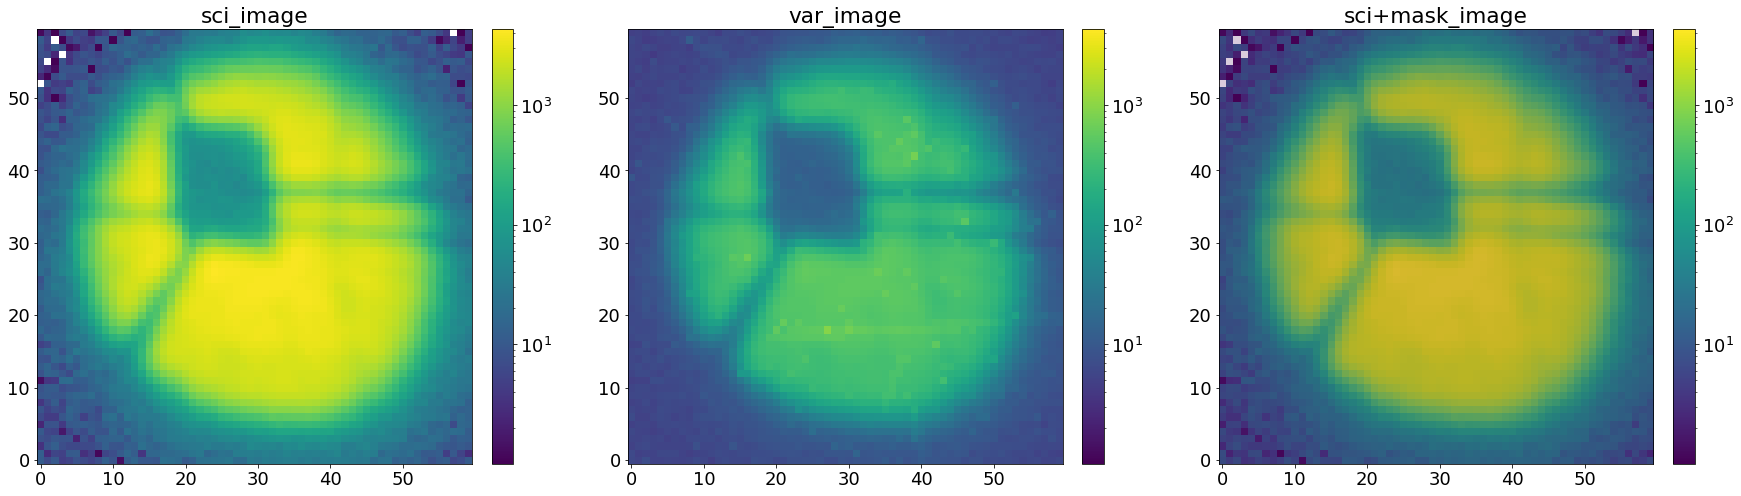

In [34]:
single_analysis=Zernike_Analysis(date=date,obs='m4',single_number=single_number,eps=eps,arc=arc,dataset=dataset,multi_var=True,\
                                 list_of_defocuses=list_of_defocuses_input_short_with_focus)
single_analysis.create_basic_data_image()

In [35]:
double_sources,double_sources_positions_ratios=single_analysis.return_double_sources()
list_of_sci_images,list_of_var_images,list_of_mask_images=single_analysis.return_lists_of_images()
index_of_single_image=single_analysis.return_index_of_single_image_in_list_of_images()
columns,columns22,columns22_analysis=single_analysis.return_columns()


chain0_swarm_1,likechain0_swarm_1=single_analysis.create_chains_swarm_1()
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains_Emcee_2()
len_of_chains=single_analysis.len_of_chains()

minchain_parametrization,like_min=single_analysis.create_likelihood()

create_chains_swarm_1: Swarm1 and likechainSwarm1 found
Path searched was: /tigress/ncaplar/Results/chainSep0521_Single_P_34437118ArSwarm1.npy
create_chains_swarm_1: Swarm1 and likechainSwarm1 found
Path searched was: /tigress/ncaplar/Results/chainSep0521_Single_P_34437118ArSwarm1.npy
(51, 480, 129)
minimal likelihood is: 5.378182543044152


### image analysis 

In [36]:
zmax_estimated = int((len(minchain_parametrization)-23)/2+3)
print('zmax number estimated from the size of minchain: ' + str(zmax_estimated))

zmax number estimated from the size of minchain: 56


In [37]:
DATAFRAMES_FOLDER='/tigress/ncaplar/PFS/Fit_Results/Apr1822/'

results_of_int_many_Ar_Apr1822=np.load(DATAFRAMES_FOLDER + 'results_of_fit_many_int_Ar_from_Apr1822.pkl',allow_pickle=True)
results_of_int_many_Ne_Apr1822=np.load(DATAFRAMES_FOLDER + 'results_of_fit_many_int_Ne_from_Apr1822.pkl',allow_pickle=True)
results_of_int_many_Kr_Apr1822=np.load(DATAFRAMES_FOLDER + 'results_of_fit_many_int_Kr_from_Apr1822.pkl',allow_pickle=True)

In [55]:
model_multi=LN_PFS_multi_same_spot(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,
                                   wavelength=wavelength,dithering=1,save=1,zmax=56,verbosity=1,\
            pupil_parameters=None,use_pupil_parameters=None,use_optPSF=None,list_of_wf_grid=None,\
            extraZernike=None,pupilExplicit=None,simulation_00=None,
            double_sources=double_sources,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,\
            list_of_defocuses=list_of_defocuses_input_long,fit_for_flux=True,test_run=False,list_of_psf_positions=None,
                                  use_center_of_flux=True)   


#minchain_parametrization_test=gbest[1]
#minchain_parametrization_test[0]=minchain_parametrization_test[0]+array_of_delta_z_parametrizations_None_1_0[0]

#minchain_parametrization_test=np.copy(allparameters_parametrization_proposal_initial+array_of_delta_all_parametrizations)

interpolation = False

if interpolation == False:
    list_of_minchain=model_multi.create_list_of_allparameters(minchain_parametrization,list_of_defocuses=list_of_defocuses_input_short_with_focus,zmax=22)

    #res_multi=model_multi(list_of_minchain,return_Images=True)
    res_multi=model_multi(list_of_minchain,return_Images=True,use_only_chi=True)


    #res_multi_10=np.copy(res_multi)
    #res_multi_21=np.copy(res_multi)

    mean_res_of_multi_same_spot,list_of_single_res,list_of_single_model_image,\
                    list_of_single_allparameters,list_of_single_chi_results,array_of_psf_positions_output=res_multi
else:
    if arc=='Ar':
        list_of_minchain = [results_of_int_many_Ar_Apr1822['m4'].loc[int(single_number)][:-2].values,
                       results_of_int_many_Ar_Apr1822['0'].loc[int(single_number)][:-2].values,
                       results_of_int_many_Ar_Apr1822['p4'].loc[int(single_number)][:-2].values]
    if arc=='Ne':
        list_of_minchain = [results_of_int_many_Ne_Apr1822['m4'].loc[int(single_number)][:-2].values,
                       results_of_int_many_Ne_Apr1822['0'].loc[int(single_number)][:-2].values,
                       results_of_int_many_Ne_Apr1822['p4'].loc[int(single_number)][:-2].values]
    if arc=='Kr':
        list_of_minchain = [results_of_int_many_Kr_Apr1822['m4'].loc[int(single_number)][:-2].values,
                       results_of_int_many_Kr_Apr1822['0'].loc[int(single_number)][:-2].values,
                       results_of_int_many_Kr_Apr1822['p4'].loc[int(single_number)][:-2].values]
    
    res_multi=model_multi(list_of_minchain,return_Images=True,use_only_chi=True)


    #res_multi_10=np.copy(res_multi)
    #res_multi_21=np.copy(res_multi)

    mean_res_of_multi_same_spot,list_of_single_res,list_of_single_model_image,\
                    list_of_single_allparameters,list_of_single_chi_results,array_of_psf_positions_output=res_multi

################################
analyzing image 1 out of 3
 
Science image shape is: (60, 60)
Top left pixel value of the science image is: 11.366353
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 6.2264752
Mask image shape is: (60, 60)
Sum of mask image is: 0
Dithering value is: 1

explicit_psf_position in LN_PFS_single: None
supplied extra Zernike parameters (beyond zmax): None
np.__version__1.16.2
scipy.__version__1.5.2
 
Initializing ZernikeFitterPFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 56

Entering lnlike_Neven
allparameters [   26.63723516    -2.42499323    -1.15663254    -0.30178522
     0.66610255    -0.42610313    -0.45754395     0.73487577
     0.0655484      0.21950631    -0.11495983    -0.00656546
     0.0189414      0.10879935    -0.00013396    -0.03169288
    -0.06389729    -0.00519323     0.10324048     0.704435
     0.10030082    -0.21135845     0.27341834     0.06388399
     0.10673329     0.1292091      0.2

KeyError: 'hscFrac'

In [17]:
popt_for_custom_var = create_popt_for_custom_var(sci_image=list_of_sci_images[index_of_single_image],
                            var_image=list_of_var_images[index_of_single_image],
                            mask_image=list_of_mask_images[index_of_single_image])
custom_var = create_custom_var_from_popt(model_image=list_of_single_model_image[index_of_single_image], popt = popt_for_custom_var)

In [18]:
list_of_var_images_via_model=[]
for index_of_single_image in range(len(list_of_sci_images)):
    
    popt_for_custom_var = create_popt_for_custom_var(sci_image=list_of_sci_images[index_of_single_image],
                            var_image=list_of_var_images[index_of_single_image],
                            mask_image=list_of_mask_images[index_of_single_image])
    single_var_image_via_model = create_custom_var_from_popt(model_image=list_of_single_model_image[index_of_single_image], popt = popt_for_custom_var)
   
    list_of_var_images_via_model.append(single_var_image_via_model)

In [19]:
use_only_chi=True


array_of_var_sum=np.array(list(map(np.sum,list_of_var_images)))
index_of_max_var_sum=np.where(array_of_var_sum==np.min(array_of_var_sum))[0][0]
# find what variance selectes top 20% of pixels
# this is done to weight more the images in focus and less the image out of focus in the 
# final likelihood result
quantile_08_focus=np.quantile(list_of_sci_images[index_of_max_var_sum],0.8)




list_of_var_sums=[]
for i in range(len(list_of_sci_images)):
    var_image_masked=list_of_var_images[i]
    sci_image=list_of_sci_images[i]
    

    mean_value_of_background=np.mean([np.median(var_image_masked[0]),np.median(var_image_masked[-1]),\
                          np.median(var_image_masked[:,0]),np.median(var_image_masked[:,-1])])*3
    #print(mean_value_of_background)
 
    #flux_mask=sci_image>(mean_value_of_background)
    #var_image_masked=var_image[flux_mask]
    
    var_image_masked_without_nan = var_image_masked.ravel()[var_image_masked.ravel()>quantile_08_focus]
    #print('number of pixels considering in image '+str(i)+': '+str(var_image_masked_without_nan.shape[0]))
    var_sum=-(1/2)*(np.sum(np.log(2*np.pi*var_image_masked_without_nan)))
    
    if use_only_chi==True:
        var_sum=-(1)*(np.mean(np.abs(var_image_masked_without_nan)))
    list_of_var_sums.append(var_sum)
    
array_of_var_sum=np.array(list_of_var_sums)
max_of_array_of_var_sum=np.max(array_of_var_sum)
print('array_of_var_sum '+str(array_of_var_sum))
renormalization_of_var_sum=array_of_var_sum/max_of_array_of_var_sum

renormalization_of_var_sum

array_of_var_sum=np.array(list(map(np.sum,list_of_var_images)))
index_of_max_var_sum=np.where(array_of_var_sum==np.min(array_of_var_sum))[0][0]
# find what variance selectes top 20% of pixels
# this is done to weight more the images in focus and less the image out of focus in the 
# final likelihood result

quantile_08_focus=np.quantile(list_of_sci_images[index_of_max_var_sum],0.8)
'model pixels with a flux larger than (quantile_08_focus): '+str(quantile_08_focus)

array_of_var_sum [-215.87121582 -127.20812225 -242.25369263]


'model pixels with a flux larger than (quantile_08_focus): 16.822856903076207'

mean reported value:-6.1420873575597055
array_of_single_res: [-6.63251899 -4.57735561 -7.21638748]
renormalization factors: [1. 1. 1.]
array_of_single_res renormalized: [-6.63251899 -4.57735561 -7.21638748]


([<matplotlib.axis.XTick at 0x2b73c1842c50>,
 <a list of 3 Text xticklabel objects>)

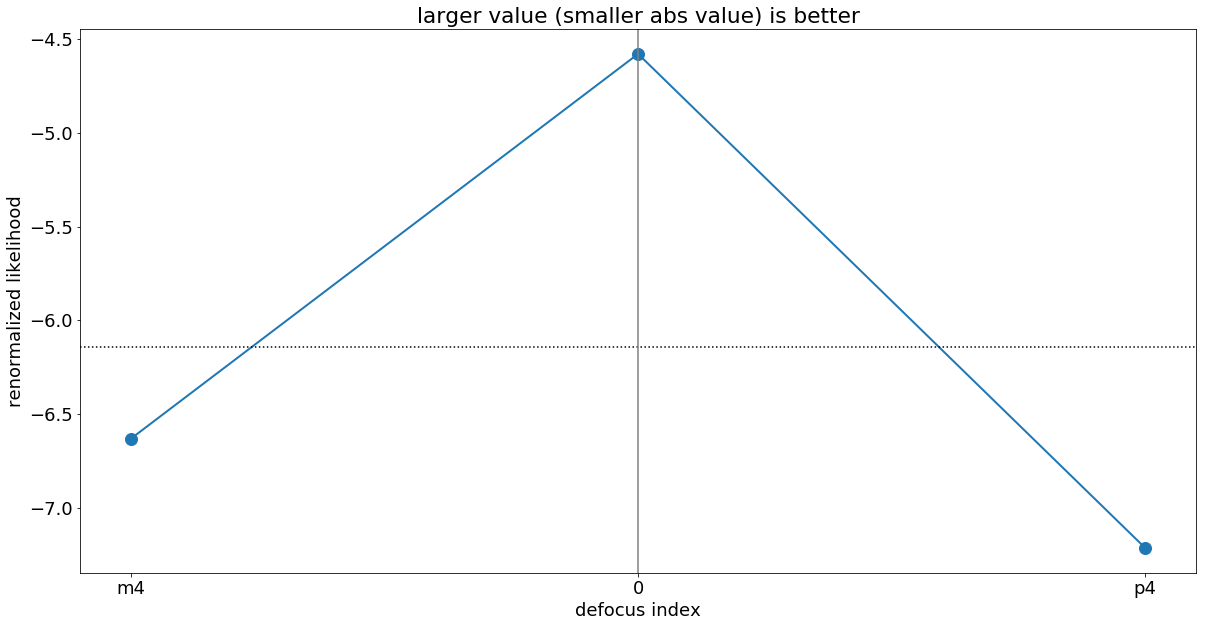

In [20]:
# shows the reported likelihood for each image, after division by the renormalization factor
# smaller absolute values is better
# dotted lien shows the mean reported value

plt.figure(figsize=(20,10))
array_of_single_res=np.array(list_of_single_res)


renormalization_of_var_sum=np.ones(len(list_of_sci_images))


mean_res_of_multi_same_spot=np.mean(array_of_single_res/renormalization_of_var_sum)
print('mean reported value:'+str(mean_res_of_multi_same_spot))
print('array_of_single_res: '+str(array_of_single_res))
print('renormalization factors: '+str(renormalization_of_var_sum))
print('array_of_single_res renormalized: '+str(array_of_single_res/renormalization_of_var_sum))
plt.plot(array_of_single_res/renormalization_of_var_sum,marker='o',lw=2,ms=12)
plt.xlabel('defocus index')
plt.ylabel('renormalized likelihood')
plt.axhline(mean_res_of_multi_same_spot,color='black',ls=":")
plt.title('larger value (smaller abs value) is better')

plt.axvline(np.where(np.array(list_of_defocuses_input_short_with_focus)=='0')[0][0],color='gray')
plt.xticks(np.arange(len(list_of_defocuses_input_short_with_focus)),list_of_defocuses_input_short_with_focus)

In [21]:
minchain=list_of_minchain[1]
#minchain[31] =0.937288
print('minchain.shape '+str(minchain.shape))

    
dfz11 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns22[0:8])
print(dfz11)
print('##############################################')
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][8:19]]),columns=columns22[8:19])
print(dfz22)

print('')
#dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][19:len(columns)]]),columns=columns[19:])
print('##############################################')
dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][19:19+6]]),columns=columns22[19:19+6])
print(dfglobal1)
print('##############################################')
dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][25:25+4]]),columns=columns22[25:25+4])
print(dfglobal2)
print('##############################################')
dfglobal3 = pd.DataFrame(np.array([np.array([minchain])[0][29:29+5]]),columns=columns22[29:29+5])
print(dfglobal3)
print('##############################################')
dfglobal4 = pd.DataFrame(np.array([np.array([minchain])[0][34:41]]),columns=columns22[34:41])
print(dfglobal4)

minchain.shape (42,)
         z4        z5        z6       z7        z8        z9       z10  \
0  0.179139 -0.733547 -0.422802 -0.31024  0.414465 -0.362545 -0.511088   

        z11  
0  0.503443  
##############################################
        z12       z13       z14       z15       z16       z17       z18  \
0  0.048085  0.179181 -0.031924  0.008576  0.056128  0.045181  0.022216   

        z19       z20       z21       z22  
0 -0.030397 -0.044897  0.020835  0.046362  

##############################################
    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy
0  0.704435   0.100301 -0.211358  0.273418  0.063884     0.106733
##############################################
     wide_0   wide_23   wide_43  misalign
0  0.129209  0.268187  0.244579  1.128544
##############################################
    x_fiber   y_fiber  effective_radius_illumination  frd_sigma  \
0 -0.033611 -0.012692                       0.876423   0.030778   

   frd_lorentz_factor  

(-1.5, -0.5)

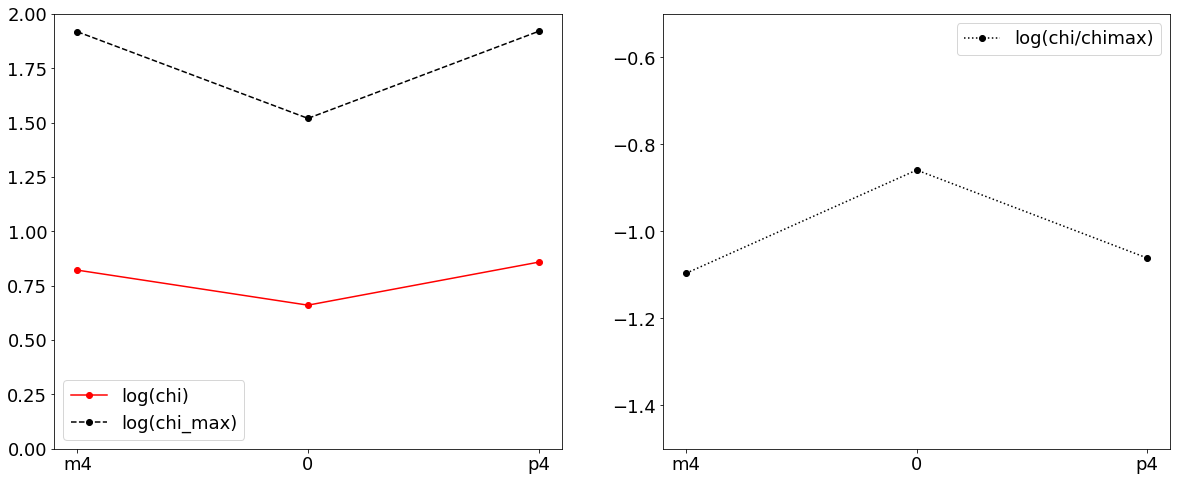

In [22]:
chi_results_array=np.array(res_multi[4])

plt.figure(figsize=(20,8))

plt.subplot(121)

plt.plot(np.log10(chi_results_array[:,2]),color='red',label='log(chi)',marker='o')
#plt.plot(np.log10(chi_results_array[:,3])-2.3,color='black',label='log(chi**2_max)-2.3',marker='o')
plt.plot(np.log10(chi_results_array[:,3]),color='black',label='log(chi_max)',marker='o',ls='--')
plt.ylim(0,2)
plt.xticks(np.arange(0,len(list_of_defocuses_input_short_with_focus),1),list_of_defocuses_input_short_with_focus)
plt.legend()
plt.subplot(122)

plt.plot(np.log10(chi_results_array[:,2]/chi_results_array[:,3]),color='black',label='log(chi/chimax)',marker='o',ls=':')
plt.legend()
plt.xticks(np.arange(0,len(list_of_defocuses_input_short_with_focus),1),list_of_defocuses_input_short_with_focus)
#plt.ylim(-2.8,-1.5)
plt.ylim(-1.5,-0.5)

Science image shape is: (60, 60)
Top left pixel value of the science image is: 11.366353
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 6.2264752
Mask image shape is: (60, 60)
Sum of mask image is: 0
Dithering value is: 1

explicit_psf_position in LN_PFS_single: None
supplied extra Zernike parameters (beyond zmax): None
np.__version__1.16.2
scipy.__version__1.5.2
 
Initializing ZernikeFitterPFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 56
3x mean_value_of_background via sci is estimated to be: 45.24108123779297
---------------------
chi**2 max reduced is: 6690.332997036663
chi**2 reduced is: 60.102166098085945 for log improvement: -2.0465576100124356
chi max reduced is: 60.92822609622985
chi reduced is: 5.203447365251332 for log improvement: -1.0685273681036922
---------------------
chi**2 reduced within custom mask area is: 60.10216614047252
---------------------
chi**2 max reduced within flux mask area is: 9560.063903560978
chi*

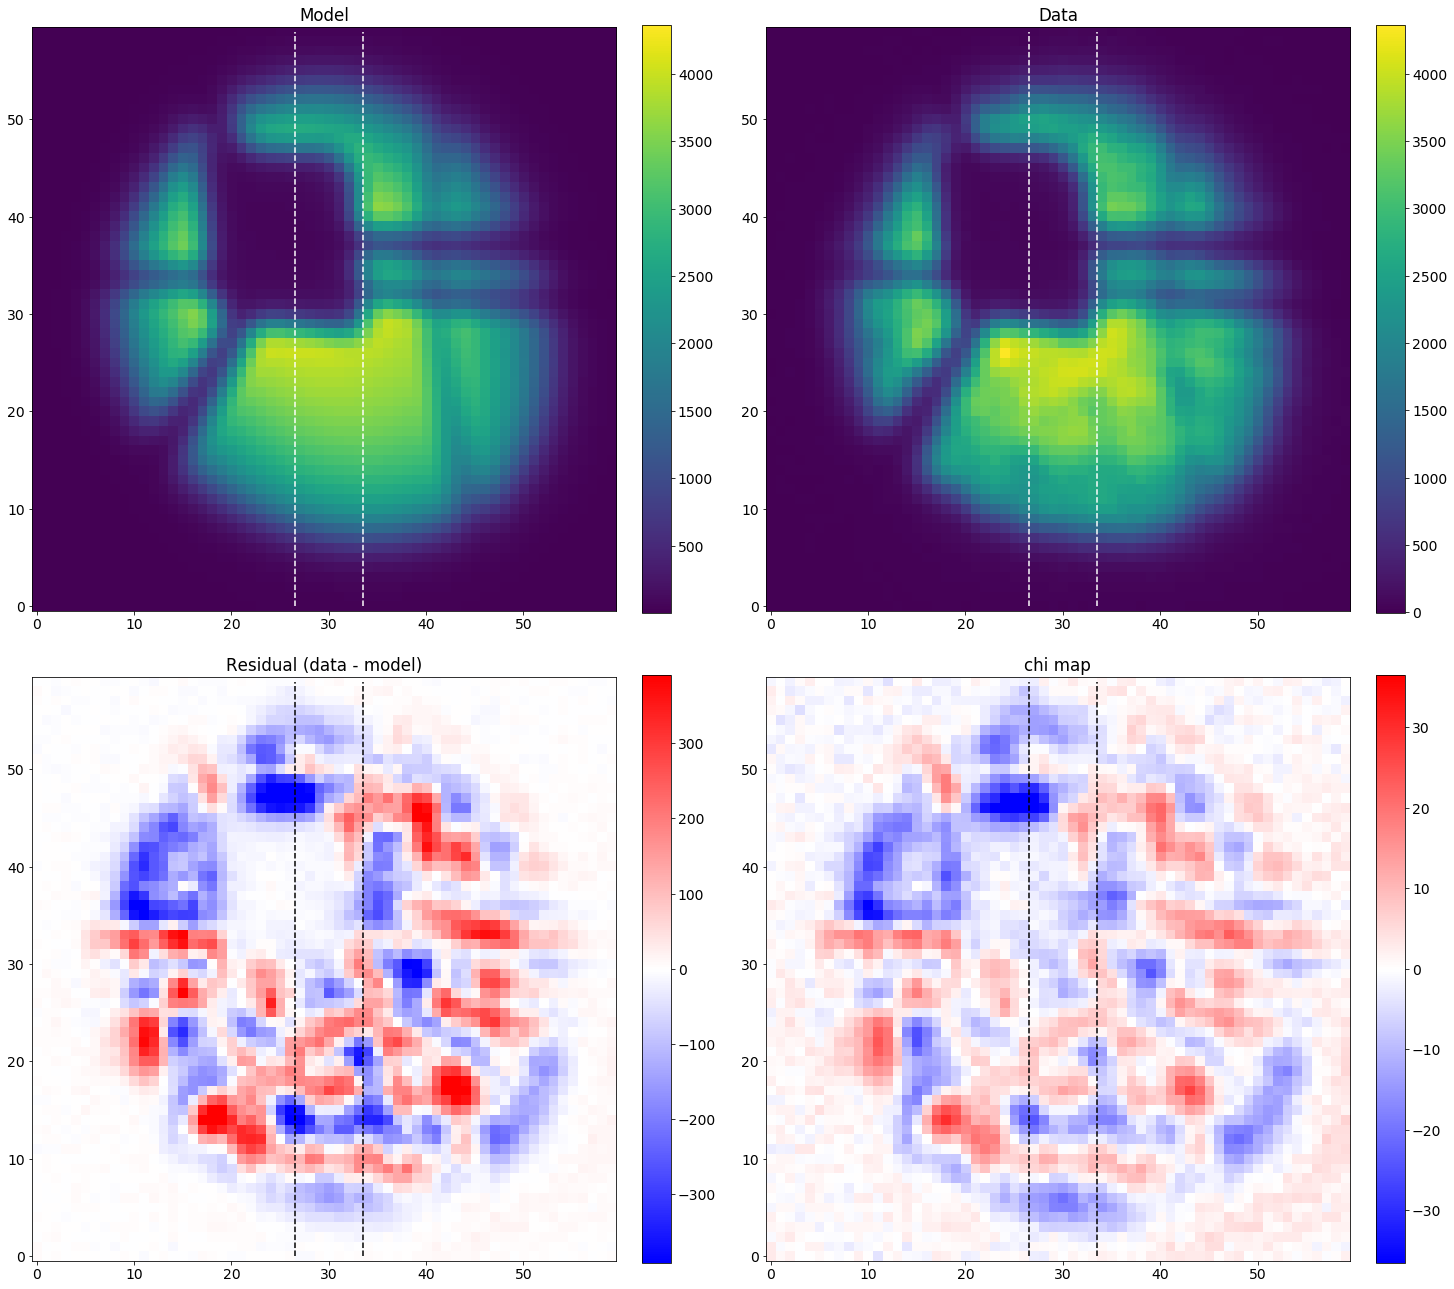

In [54]:
index_of_single_image=0

#
model_single_image = LN_PFS_single(list_of_sci_images[index_of_single_image],list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image],\
                                   dithering=1,save=0,zmax=56,verbosity=1,\
                                   double_sources=double_sources,double_sources_positions_ratios=double_sources_positions_ratios,fit_for_flux=True,npix=1536)

popt_for_custom_var = create_popt_for_custom_var(sci_image=list_of_sci_images[index_of_single_image],
                            var_image=list_of_var_images[index_of_single_image],
                            mask_image=list_of_mask_images[index_of_single_image])
custom_var = create_custom_var_from_popt(model_image=list_of_single_model_image[index_of_single_image], popt = popt_for_custom_var)

# custom_var=model_single_image.create_custom_var(modelImg=list_of_single_model_image[index_of_single_image],sci_image=list_of_sci_images[index_of_single_image],
#                                   var_image=list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image])

matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot(custom_model_image=list_of_single_model_image[index_of_single_image],\
                                             custom_mask=list_of_mask_images[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],\
                                             custom_var_image=list_of_var_images[index_of_single_image],\
                                             show_flux_mask=False,use_max_chi_scaling=True,use_max_flux_scaling=True,\
                                             show_impact_pixels_mask=False,multi_background_factor=3)

# I can move to use custom_var within the analysis
#single_analysis.create_basic_comparison_plot(custom_model_image=list_of_single_model_image[index_of_single_image],custom_mask=list_of_mask_images[index_of_single_image],\
#                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=custom_var,\
#                                             show_flux_mask=False,use_max_chi_scaling=True,use_max_flux_scaling=False)

array_of_sci_image=np.array(list_of_sci_images)
array_of_single_model_image=np.array(list_of_single_model_image)
array_of_var_images=np.array(list_of_var_images)
array_of_mask_images=np.array(list_of_mask_images)

Science image shape is: (60, 60)
Top left pixel value of the science image is: 11.366353
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 6.2264752
Mask image shape is: (60, 60)
Sum of mask image is: 0
Dithering value is: 1

explicit_psf_position in LN_PFS_single: None
supplied extra Zernike parameters (beyond zmax): None
pixelScale20.76
diam_sic0.1395327
np.__version__1.16.2
scipy.__version__1.5.2
 
Initializing ZernikeFitterPFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 56
3x mean_value_of_background via sci is estimated to be: 45.24108123779297
fraction of chi2 due to 1% of pixels: 0.1554669326294828
---------------------
chi**2 max reduced is: 6690.332997036663
chi**2 reduced is: 60.102166098085945 for log improvement: -2.0465576100124356
chi max reduced is: 60.92822609622985
chi reduced is: 5.203447365251332 for log improvement: -1.0685273681036922
---------------------
chi**2 reduced within custom mask area is: 60.1021661404725

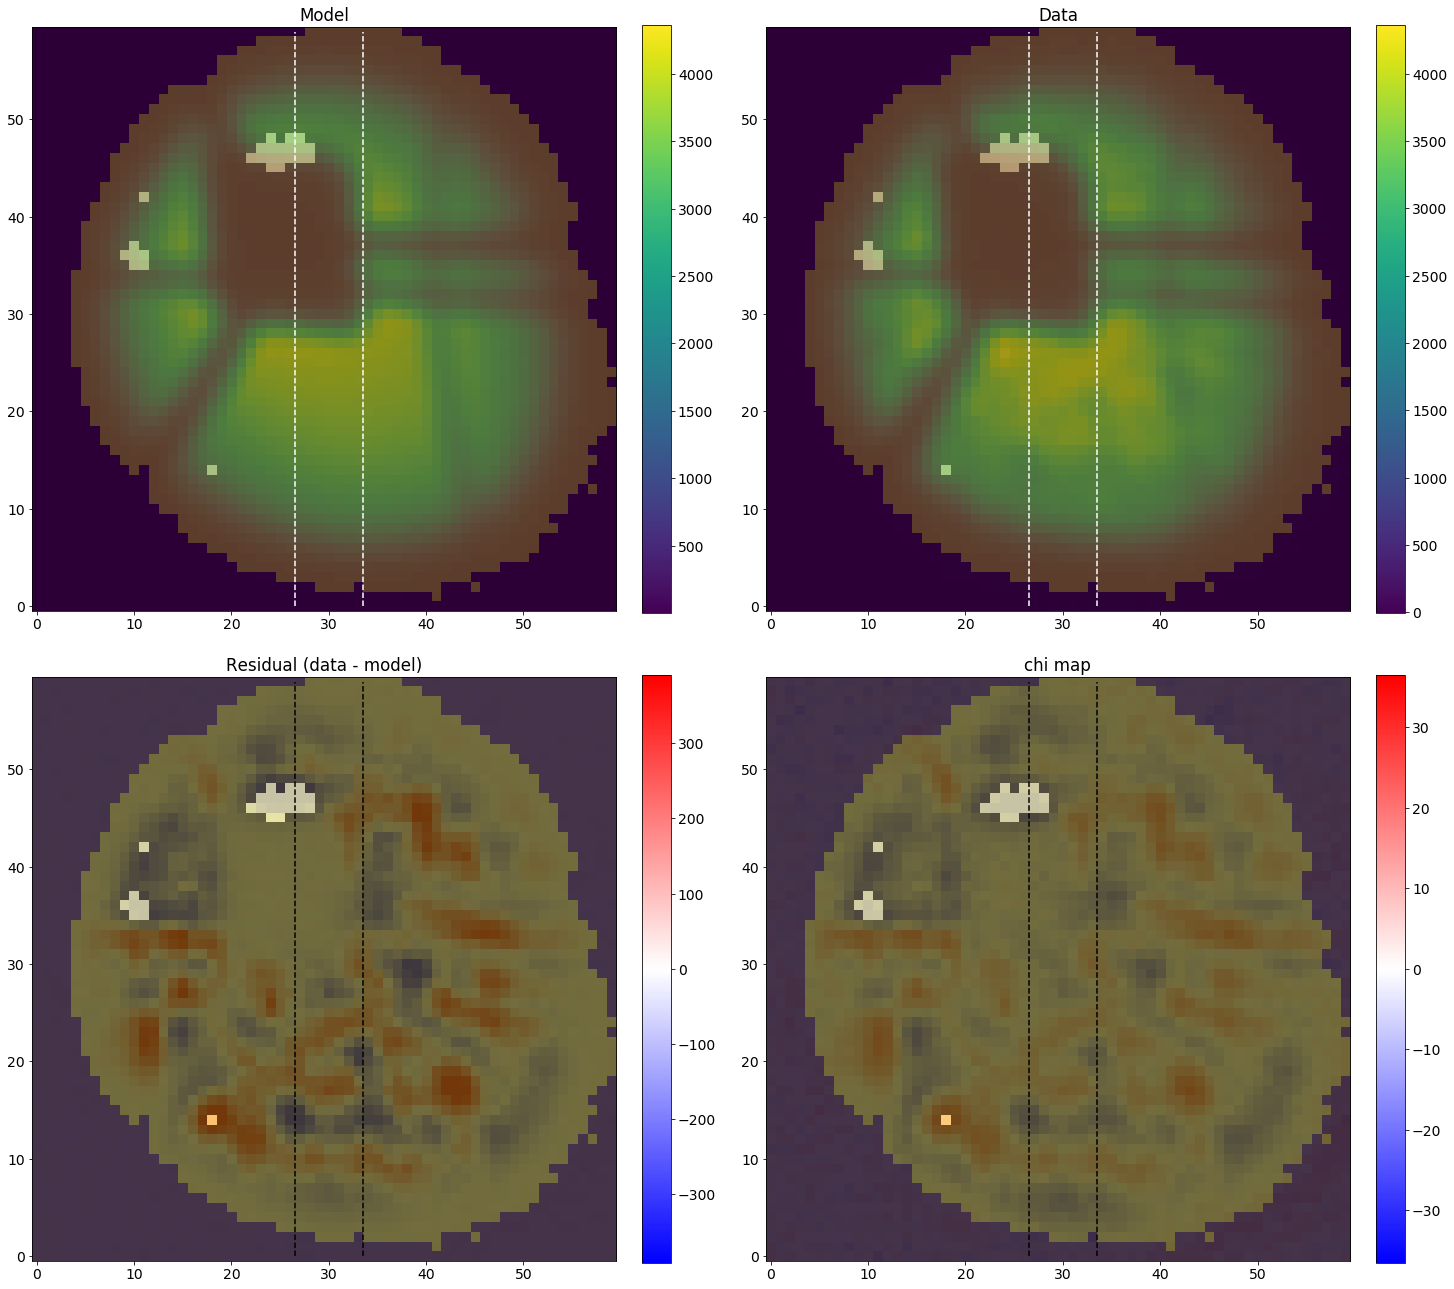

In [53]:
model_single_image = LN_PFS_single(list_of_sci_images[index_of_single_image],list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image],\
                                   dithering=1,save=0,zmax=56,verbosity=1,\
                                   double_sources=double_sources,double_sources_positions_ratios=double_sources_positions_ratios,fit_for_flux=True,npix=1536)

custom_var=model_single_image.create_custom_var(model_image=list_of_single_model_image[index_of_single_image],sci_image=list_of_sci_images[index_of_single_image],
                                    var_image=list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image])

matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot(custom_model_image=list_of_single_model_image[index_of_single_image],custom_mask=list_of_mask_images[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=list_of_var_images[index_of_single_image],\
                                             show_flux_mask=True,use_max_chi_scaling=True,use_max_flux_scaling=True,show_impact_pixels_mask=True)

In [4]:
# Extra performance libraries for later
import numexpr
import numba
import numpy as np
import scipy
import scipy.fftpack

In [32]:
@numba.njit
def fft_custom_numba(expwf_grid):
    ftexpwf = np.fft.fftshift(scipy.fftpack.fft2(np.fft.fftshift(expwf_grid)))
    img_apod = np.abs(ftexpwf)**2
    return img_apod

In [27]:
def fft_custom(expwf_grid):
    ftexpwf = np.fft.fftshift(scipy.fftpack.fft2(np.fft.fftshift(expwf_grid)))
    img_apod = np.abs(ftexpwf)**2
    return img_apod

In [14]:
expwf_grid = np.load('/tigress/ncaplar/Testing/Wavefront_Images/expwf_grid.npy')

In [16]:
%timeit ftexpwf = np.fft.fftshift(scipy.fftpack.fft2(np.fft.fftshift(expwf_grid))); img_apod = np.abs(ftexpwf)**2

1 loop, best of 3: 463 ms per loop


In [33]:
fft_custom_numba(expwf_grid)

TypingError: Failed at nopython (nopython frontend)
[1m[1mUnknown attribute 'fftshift' of type Module(<module 'numpy.fft' from '/usr/licensed/anaconda/5.3.1/lib/python2.7/site-packages/numpy/fft/__init__.pyc'>)
[1m
File "<ipython-input-32-37ac58fde9a7>", line 3:[0m
[1mdef fft_custom_numba(expwf_grid):
[1m    ftexpwf = np.fft.fftshift(scipy.fftpack.fft2(np.fft.fftshift(expwf_grid)))
[0m    [1m^[0m[0m
[0m
[0m[1m[1] During: typing of get attribute at <ipython-input-32-37ac58fde9a7> (3)[0m
[1m
File "<ipython-input-32-37ac58fde9a7>", line 3:[0m
[1mdef fft_custom_numba(expwf_grid):
[1m    ftexpwf = np.fft.fftshift(scipy.fftpack.fft2(np.fft.fftshift(expwf_grid)))
[0m    [1m^[0m[0m

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


In [24]:
fft_custom(expwf_grid)

array([[0.20930655, 0.56966305, 0.40827057, ..., 0.0661767 , 0.00780152,
        0.01203255],
       [0.12991406, 0.3658852 , 0.45571387, ..., 0.12254926, 0.08383492,
        0.15257138],
       [0.03771545, 0.02017954, 0.13220918, ..., 0.0712605 , 0.06472878,
        0.146585  ],
       ...,
       [0.10367034, 0.07113148, 0.07065199, ..., 0.508572  , 0.2316218 ,
        0.00209333],
       [0.15333319, 0.11189505, 0.19537419, ..., 0.42568022, 0.36742148,
        0.09392266],
       [0.1623453 , 0.06997858, 0.0654541 , ..., 0.02911485, 0.10730913,
        0.1577881 ]], dtype=float32)

In [17]:
%timeit fft_custom(expwf_grid)

TypingError: Failed at nopython (nopython frontend)
[1mUntyped global name 'img_apot':[0m [1m[1mcannot determine Numba type of <type 'object'>[0m
[1m
File "<ipython-input-12-c6aceb896764>", line 5:[0m
[1mdef fft_custom(expwf_grid):
    <source elided>
    img_apod = np.abs(ftexpwf)**2
[1m    return img_apot
[0m    [1m^[0m[0m
[0m
This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


In [18]:
class Psf_position(object):
    """
    Class that deals with positioning the PSF model in respect to the data

    inputs are:

        image                                       oversampled model image (numpy array)
        oversampling                                by how much is the the oversampled image oversampled
        size_natural_resolution                     size of the final image
        simulation_00                               True if simulate at optical center at 0,0
        double_sources
        double_sources_positions_ratios
        verbosity
        save

    """

    def __init__(self, image, oversampling, size_natural_resolution, simulation_00=False,
                 double_sources=False, double_sources_positions_ratios=[0, 0], verbosity=0, save=None):

        self.image = image
        self.oversampling = oversampling
        self.size_natural_resolution = size_natural_resolution
        self.simulation_00 = simulation_00
        self.double_sources = double_sources
        self.double_sources_positions_ratios = double_sources_positions_ratios
        self.verbosity = verbosity
        if save is None:
            save = 0
            self.save = save
        else:
            save = 1
            self.save = save

    def cut_Centroid_of_natural_resolution_image(image, size_natural_resolution, oversampling, dx, dy):
        """
        function which takes central part of a larger oversampled image

        @param image                          array contaning suggested starting values for a model
        @param size_natural_resolution        size of new image in natural units
        @param oversampling                   oversampling
        @param dx                             how much to move in dx direction (fix)
        @param dy                             how much to move in dy direction (fix)
        """

        positions_from_where_to_start_cut = [int(len(image) /
                                                 2 -
                                                 size_natural_resolution /
                                                 2 -
                                                 dx *
                                                 oversampling +
                                                 1), int(len(image) /
                                                         2 -
                                                         size_natural_resolution /
                                                         2 -
                                                         dy *
                                                         oversampling +
                                                         1)]

        res = image[positions_from_where_to_start_cut[1]:positions_from_where_to_start_cut[1] +
                    int(size_natural_resolution),
                    positions_from_where_to_start_cut[0]:positions_from_where_to_start_cut[0] +
                    int(size_natural_resolution)]

        return res

    def find_single_realization_min_cut(
            self,
            input_image,
            oversampling,
            size_natural_resolution,
            sci_image,
            var_image,
            mask_image,
            v_flux,
            simulation_00=None,
            double_sources=None,
            double_sources_positions_ratios=[
                0,
                0],
            verbosity=0,
            explicit_psf_position=None,
            use_only_chi=False,
            use_center_of_flux=False):
        """
        function called by create_optPSF_natural in ZernikeFitter_PFS
        find what is the best starting point to downsample the oversampled image

        @param image                             image to be analyzed
                                                 (in our case this will be image of the optical psf
                                                 convolved with fiber)
        @param oversampling                      oversampling
        @param size_natural_resolution           size of final image
                                                 (in the ``natural'', i.e., physical resolution)
        @param sci_image_0                       scientific image
        @param var_image_0                       variance image
        @param v_flux                            flux normalization
        @param simulation_00                     do not move the center, for making fair comparisons between
                                                 models - optical center in the center of the image
                                                 if use_center_of_flux==True the behaviour changes
                                                 and the result is the image with center of flux
                                                 in the center of the image
        @param double_sources                    are there double sources in the image
        @param double_sources_positions_ratios   tuple describing init guess for the relation between
                                                 secondary and primary souces (offset, ratio)
        @param verbosity                         verbosity of the algorithm
        @param explicit_psf_position             x and y offset
        @param use_only_chi                      quality of the centering is measured using chi, not chi**2
        @param use_center_of_flux                fit so that the center of flux of the model and science image
                                                 is as similar as possible

        calls function create_complete_realization (many times in order to fit the best solution)


        returns model image in the size of the science image and centered to the science image
        (unless simulation_00=True or explicit_psf_position has been passed)
        """
        
        self.sci_image = sci_image
        self.var_image = var_image
        self.mask_image = mask_image
        self.v_flux = v_flux

        # if you are just asking for simulated image at (0,0) there is no possibility to create double sources
        if simulation_00 == 1:
            double_sources = None

        if double_sources is None or double_sources is False:
            double_sources_positions_ratios = [0, 0]

        shape_of_input_img = input_image.shape[0]
        shape_of_sci_image = sci_image.shape[0]
        # max_possible_value_to_analyze = int(shape_of_input_img - oversampling)
        # min_possible_value_to_analyze = int(oversampling)
        # center_point = int(shape_of_input_img / 2)

        self.shape_of_input_img = shape_of_input_img
        self.shape_of_sci_image = shape_of_sci_image

        if verbosity == 1:
            print('parameter use_only_chi in Psf_postion is set to: ' + str(use_only_chi))
            print('parameter use_center_of_flux in Psf_postion is set to: ' + str(use_center_of_flux))
            print('parameter simulation_00 in Psf_postion is set to: ' + str(simulation_00))

        # depending on if there is a second source in the image split here
        # double_sources should always be None when when creating centered images (simulation_00 = True)
        if double_sources is None or bool(double_sources) is False:
            # print('simulation_00: ' +str(simulation_00))
            # print('use_center_of_flux: '+str(use_center_of_flux))

            # if simulation_00 AND using optical center just run the realization that is set at 0,0
            if simulation_00 == 1 and use_center_of_flux is False:
                if verbosity == 1:
                    print(
                        'simulation_00 is set to 1 and use_center_of_flux==False -\
                        I am just returning the image at (0,0) coordinates ')

                # return the solution with x and y is zero, i.e., with optical center in
                # the center of the image
                mean_res, single_realization_primary_renormalized, single_realization_secondary_renormalized,\
                    complete_realization_renormalized \
                    = self.create_complete_realization([0, 0], return_full_result=True,
                                                       use_only_chi=use_only_chi,
                                                       use_center_of_light=use_center_of_flux,
                                                       simulation_00=simulation_00)

            # if you are fitting an actual image go through the full process
            else:

                # if you did not pass explict position search for the best position
                if explicit_psf_position is None:

                    # if creating the model so that the model is centered so
                    # that center of light of the model matches the center of the light
                    # of the scientific image, manually change values for centroid_of_sci_image here
                    if simulation_00 == 1 and use_center_of_flux:
                        if self.verbosity == 1:
                            print('creating simulated image, center of light in center of the image')
                        shape_of_sci_image = 21
                        centroid_of_sci_image = [10.5, 10.5]
                    else:
                        # create one complete realization with default parameters - estimate
                        # centorids and use that knowledge to put fitting limits in the next step
                        centroid_of_sci_image = find_centroid_of_flux(sci_image)

                    # changed in 0.47a from
                    # -double_sources_positions_ratios[0]*self.oversampling to
                    # double_sources_positions_ratios[0]*self.oversampling,
                    time_1 = time.time()
                    initial_complete_realization = self.create_complete_realization(
                        [
                            0,
                            0,
                            double_sources_positions_ratios[0] * self.oversampling,
                            double_sources_positions_ratios[1]],
                        return_full_result=True,
                        use_only_chi=use_only_chi,
                        use_center_of_light=use_center_of_flux,
                        simulation_00=simulation_00)[
                        -1]
                    time_2 = time.time()
                    if self.verbosity == 1:
                        print('time_2-time_1 for initial_complete_realization: ' + str(time_2 - time_1))

                    # center of the light for the first realization, set at optical center
                    centroid_of_initial_complete_realization = find_centroid_of_flux(
                        initial_complete_realization)

                    # determine offset between the initial guess and the data
                    offset_initial_and_sci = - \
                        ((np.array(find_centroid_of_flux(initial_complete_realization)) -
                          np.array(find_centroid_of_flux(sci_image))))

                    if verbosity == 1:
                        print('centroid_of_initial_complete_realization ' +
                              str(find_centroid_of_flux(initial_complete_realization)))
                        print('centroid_of_sci_image '+str(find_centroid_of_flux(sci_image)))
                        print('offset_initial_and_sci: ' + str(offset_initial_and_sci))
                        print('[x_primary, y_primary, y_secondary,ratio_secondary] / chi2 output')
                    if self.save == 1:
                        np.save(
                            TESTING_FINAL_IMAGES_FOLDER +
                            'initial_complete_realization',
                            initial_complete_realization)

                    # search for the best center using scipy ``shgo'' algorithm
                    # set the limits for the fitting procedure
                    y_2sources_limits = [
                        (offset_initial_and_sci[1] - 2) * self.oversampling,
                        (offset_initial_and_sci[1] + 2) * self.oversampling]
                    x_2sources_limits = [
                        (offset_initial_and_sci[0] - 1) * self.oversampling,
                        (offset_initial_and_sci[0] + 1) * self.oversampling]
                    # search for best positioning

                    # if use_center_of_flux==True, we use more direct approach to get to the center

                    if use_center_of_flux:
                        for i in range(5):
                            if verbosity == 1:
                                print("###")

                            if i == 0:

                                x_i, y_i = offset_initial_and_sci * oversampling

                                x_offset, y_offset = 0, 0
                                x_offset = x_offset + x_i
                                y_offset = y_offset + y_i
                            else:
                                x_offset = x_offset + x_i
                                y_offset = y_offset + y_i
                            # complete_realization=self.create_complete_realization(x=[x_offset,y_offset,0,0,],\
                            #                                                      return_full_result=True,use_only_chi=True,use_center_of_light=True,simulation_00=False)[-1]
                            complete_realization = self.create_complete_realization(
                                x=[x_offset, y_offset, 0, 0, ], return_full_result=True, use_only_chi=True,
                                use_center_of_light=True, simulation_00=simulation_00)[-1]
                            offset_initial_and_sci = -((np.array(find_centroid_of_flux(complete_realization))
                                                        - np.array(find_centroid_of_flux(sci_image))))
                            if verbosity == 1:
                                print('offset_initial_and_sci in step ' +
                                      str(i) + ' ' + str(offset_initial_and_sci))
                                print("###")
                            x_i, y_i = offset_initial_and_sci * oversampling

                        primary_position_and_ratio_x = [x_offset, y_offset]
                    # if use_center_of_flux=False, we have to optimize to find the best solution
                    else:
                        # implement try syntax for secondary too
                        try:
                            # print('simulation_00 here is: '+str(simulation_00))
                            # print('(False, use_only_chi,use_center_of_flux)' +
                            #       str((False, use_only_chi, use_center_of_flux)))
                            # print('x_2sources_limits' + str(x_2sources_limits))
                            # print('y_2sources_limits' + str(y_2sources_limits))
                            primary_position_and_ratio_shgo = scipy.optimize.shgo(
                                self.create_complete_realization,
                                args=(
                                    False,
                                    use_only_chi,
                                    use_center_of_flux,
                                    simulation_00),
                                bounds=[
                                    (x_2sources_limits[0],
                                     x_2sources_limits[1]),
                                    (y_2sources_limits[0],
                                     y_2sources_limits[1])],
                                n=10,
                                sampling_method='sobol',
                                options={
                                    'ftol': 1e-3,
                                    'maxev': 10})

                            # primary_position_and_ratio=primary_position_and_ratio_shgo
                            primary_position_and_ratio = scipy.optimize.minimize(
                                self.create_complete_realization,
                                args=(
                                    False,
                                    use_only_chi,
                                    use_center_of_flux,
                                    simulation_00),
                                x0=primary_position_and_ratio_shgo.x,
                                method='Nelder-Mead',
                                options={
                                    'xatol': 0.00001,
                                    'fatol': 0.00001})

                            primary_position_and_ratio_x = primary_position_and_ratio.x
                        except BaseException as e:
                            print(e)
                            print('search for primary position failed')
                            primary_position_and_ratio_x = [0, 0]

                    # return the best result, based on the result of the conducted search
                    mean_res, single_realization_primary_renormalized,\
                    single_realization_secondary_renormalized, complete_realization_renormalized \
                        = self.create_complete_realization(primary_position_and_ratio_x,
                                                           return_full_result=True,
                                                           use_only_chi=use_only_chi,
                                                           use_center_of_light=use_center_of_flux,
                                                           simulation_00=simulation_00)

                    if self.save == 1:
                        np.save(
                            TESTING_FINAL_IMAGES_FOLDER +
                            'single_realization_primary_renormalized',
                            single_realization_primary_renormalized)
                        np.save(
                            TESTING_FINAL_IMAGES_FOLDER +
                            'single_realization_secondary_renormalized',
                            single_realization_secondary_renormalized)
                        np.save(
                            TESTING_FINAL_IMAGES_FOLDER +
                            'complete_realization_renormalized',
                            complete_realization_renormalized)

                    if self.verbosity == 1:
                        if simulation_00 != 1:
                            print('We are fitting for only one source')
                            print('One source fitting result is ' + str(primary_position_and_ratio_x))
                            print('type(complete_realization_renormalized)' +
                                  str(type(complete_realization_renormalized[0][0])))

                            centroid_of_complete_realization_renormalized = find_centroid_of_flux(
                                complete_realization_renormalized)

                            # determine offset between the initial guess and the data
                            offset_final_and_sci = - \
                                (np.array(centroid_of_complete_realization_renormalized) -
                                 np.array(centroid_of_sci_image))

                            print('offset_final_and_sci: ' + str(offset_final_and_sci))

                    return complete_realization_renormalized, primary_position_and_ratio_x

                # if you did pass explicit_psf_position for the solution evalute the code here
                else:

                    mean_res, single_realization_primary_renormalized,\
                    single_realization_secondary_renormalized, complete_realization_renormalized\
                        = self.create_complete_realization(explicit_psf_position,
                                                           return_full_result=True,
                                                           use_only_chi=use_only_chi,
                                                           use_center_of_light=use_center_of_flux)

                    if self.save == 1:
                        np.save(
                            TESTING_FINAL_IMAGES_FOLDER +
                            'single_realization_primary_renormalized',
                            single_realization_primary_renormalized)
                        np.save(
                            TESTING_FINAL_IMAGES_FOLDER +
                            'single_realization_secondary_renormalized',
                            single_realization_secondary_renormalized)
                        np.save(
                            TESTING_FINAL_IMAGES_FOLDER +
                            'complete_realization_renormalized',
                            complete_realization_renormalized)

                    if self.verbosity == 1:
                        if simulation_00 != 1:
                            print('We are passing value for only one source')
                            print('One source fitting result is ' + str(explicit_psf_position))
                            print('type(complete_realization_renormalized)' +
                                  str(type(complete_realization_renormalized[0][0])))

                    return complete_realization_renormalized, explicit_psf_position

        else:
            # TODO: need to make possible that you can pass your own values for double source!!!!

            # create one complete realization with default parameters - estimate
            # centroids and use that knowledge to put fitting limits in the next step
            centroid_of_sci_image = find_centroid_of_flux(sci_image)
            # print('initial double_sources_positions_ratios is: '+str(double_sources_positions_ratios))
            initial_complete_realization = self.create_complete_realization([0,
                                                                             0,
                                                                             double_sources_positions_ratios[0] #noqa: E501
                                                                             * self.oversampling,
                                                                             double_sources_positions_ratios[1]], #noqa: E501
                                                                            return_full_result=True,
                                                                            use_only_chi=use_only_chi,
                                                                            use_center_of_light= #noqa: E251
                                                                            use_center_of_flux,
                                                                            simulation_00=simulation_00)[-1]
            centroid_of_initial_complete_realization = find_centroid_of_flux(initial_complete_realization)

            # determine offset between the initial guess and the data
            offset_initial_and_sci = - \
                (np.array(centroid_of_initial_complete_realization) - np.array(centroid_of_sci_image))

            if verbosity == 1:

                print('Evaulating double source psf positioning loop')
                print('offset_initial_and_sci: ' + str(offset_initial_and_sci))
                print('[x_primary, y_primary, y_secondary,ratio_secondary] / chi2 output')

            if self.save == 1:
                np.save(TESTING_FINAL_IMAGES_FOLDER + 'sci_image', sci_image)
                np.save(TESTING_FINAL_IMAGES_FOLDER + 'initial_complete_realization',
                        initial_complete_realization)

            # implement that it does not search if second object far away while in focus
            # focus size is 20
            if shape_of_sci_image == 20 and np.abs(self.double_sources_positions_ratios[0]) > 15:
                if verbosity == 1:
                    print('fitting second source, but assuming that second source is too far')

                # if the second spot is more than 15 pixels away
                # copying code from the non-double source part
                # search for the best center using scipy ``shgo'' algorithm
                # set the limits for the fitting procedure
                y_2sources_limits = [
                    (offset_initial_and_sci[1] - 2) * self.oversampling,
                    (offset_initial_and_sci[1] + 2) * self.oversampling]
                x_2sources_limits = [
                    (offset_initial_and_sci[0] - 1) * self.oversampling,
                    (offset_initial_and_sci[0] + 1) * self.oversampling]
                # search for best positioning
                # implement try for secondary too
                try:
                    # print('(False,use_only_chi,use_center_of_flux)'+str((False,use_only_chi,use_center_of_flux)))
                    primary_position_and_ratio_shgo = scipy.optimize.shgo(
                        self.create_complete_realization,
                        args=(
                            False,
                            use_only_chi,
                            use_center_of_flux,
                            simulation_00),
                        bounds=[
                            (x_2sources_limits[0],
                             x_2sources_limits[1]),
                            (y_2sources_limits[0],
                             y_2sources_limits[1])],
                        n=10,
                        sampling_method='sobol',
                        options={
                            'ftol': 1e-3,
                            'maxev': 10})

                    if verbosity == 1:
                        print('starting finer positioning')

                    # primary_position_and_ratio=primary_position_and_ratio_shgo
                    primary_position_and_ratio = scipy.optimize.minimize(
                        self.create_complete_realization,
                        args=(
                            False,
                            use_only_chi,
                            use_center_of_flux,
                            simulation_00),
                        x0=primary_position_and_ratio_shgo.x,
                        method='Nelder-Mead',
                        options={
                            'xatol': 0.00001,
                            'fatol': 0.00001})

                    primary_position_and_ratio_x = primary_position_and_ratio.x
                except BaseException:
                    print('search for primary position failed')
                    primary_position_and_ratio_x = [0, 0]

                primary_secondary_position_and_ratio_x = np.array([0., 0., 0., 0.])
                primary_secondary_position_and_ratio_x[0] = primary_position_and_ratio_x[0]
                primary_secondary_position_and_ratio_x[1] = primary_position_and_ratio_x[1]

            else:

                # set the limits for the fitting procedure
                y_2sources_limits = [
                    (offset_initial_and_sci[1] - 2) * self.oversampling,
                    (offset_initial_and_sci[1] + 2) * self.oversampling]
                x_2sources_limits = [
                    (offset_initial_and_sci[0] - 1) * self.oversampling,
                    (offset_initial_and_sci[0] + 1) * self.oversampling]
                y_2sources_limits_second_source = [
                    (self.double_sources_positions_ratios[0] - 2) * oversampling,
                    (self.double_sources_positions_ratios[0] + 2) * oversampling]

                # search for best result
                # x position, y_position_1st, y_position_2nd, ratio

                primary_secondary_position_and_ratio = scipy.optimize.shgo(
                    self.create_complete_realization,
                    args=(
                        False,
                        use_only_chi,
                        use_center_of_flux,
                        simulation_00),
                    bounds=[
                        (x_2sources_limits[0],
                         x_2sources_limits[1]),
                        (y_2sources_limits[0],
                         y_2sources_limits[1]),
                        (y_2sources_limits_second_source[0],
                         y_2sources_limits_second_source[1]),
                        (self.double_sources_positions_ratios[1] / 2,
                         2 * self.double_sources_positions_ratios[1])],
                    n=10,
                    sampling_method='sobol',
                    options={
                        'ftol': 1e-3,
                        'maxev': 10})

                primary_secondary_position_and_ratio_x = primary_secondary_position_and_ratio.x

            # primary_secondary_position_and_ratio=scipy.optimize.shgo(self.create_complete_realization,(False,use_only_chi,use_center_of_flux),bounds=\
            #                                                         [(x_2sources_limits[0],x_2sources_limits[1]),(y_2sources_limits[0],y_2sources_limits[1]),\
            #                                                          (y_2sources_limits_second_source[0],y_2sources_limits_second_source[1]),\
            #                                                          (self.double_sources_positions_ratios[1]/2,2*self.double_sources_positions_ratios[1])],n=10,sampling_method='sobol',\
            #                                                          options={'maxev':10,'ftol':1e-3})

            # return best result
            # introduce best_result=True
            mean_res, single_realization_primary_renormalized,
            single_realization_secondary_renormalized, complete_realization_renormalized \
                = self.create_complete_realization(primary_secondary_position_and_ratio_x,
                                                   return_full_result=True, use_only_chi=use_only_chi,
                                                   use_center_of_light=use_center_of_flux,
                                                   simulation_00=simulation_00)

            if self.save == 1:
                np.save(
                    TESTING_FINAL_IMAGES_FOLDER +
                    'single_realization_primary_renormalized',
                    single_realization_primary_renormalized)
                np.save(
                    TESTING_FINAL_IMAGES_FOLDER +
                    'single_realization_secondary_renormalized',
                    single_realization_secondary_renormalized)
                np.save(
                    TESTING_FINAL_IMAGES_FOLDER +
                    'complete_realization_renormalized',
                    complete_realization_renormalized)

            if self.verbosity == 1:
                print('We are fitting for two sources')
                print('Two source fitting result is ' + str(primary_secondary_position_and_ratio_x))
                print('type(complete_realization_renormalized)' +
                      str(type(complete_realization_renormalized[0][0])))

        return complete_realization_renormalized, primary_secondary_position_and_ratio_x

    def create_complete_realization(
            self,
            x,
            return_full_result=False,
            use_only_chi=False,
            use_center_of_light=False,
            simulation_00=None):
        # need to include masking
        """
        create one complete downsampled realization of the image, from the full oversampled image

        @param     x                            array contaning x_primary, y_primary,
                                                offset in y to secondary source, \
                                                ratio in flux from secondary to primary;
                                                the units are oversampled pixels(?)
        @bol       return_full_result           if True, returns the images iteself (not just chi**2)
        @bol       use_only_chi                 if True, minimize chi; if False, minimize chi^2
        @bol       use_center_of_light          if True, minimize distance to center of light,
        in focus (if size==20)

        called by find_single_realization_min_cut - has to be done via that function,
        to supply self.sci_image etc...

        calls create_chi_2_almost_Psf_position
        """

        # oversampled input image
        image = self.image

        sci_image = self.sci_image
        var_image = self.var_image
        mask_image = self.mask_image
        shape_of_sci_image = self.size_natural_resolution

        oversampling = self.oversampling
        v_flux = self.v_flux

        # central position of the create oversampled image
        center_position = int(np.floor(image.shape[0] / 2))
        # to be applied on x-axis
        print(x)
        primary_offset_axis_1 = x[0]
        # to be applied on y-axis
        primary_offset_axis_0 = x[1]
        if simulation_00 == 1:
            simulation_00 = True

        # print('simulation_00 in create_complete_realization:' +str(simulation_00))
        # if you are only fitting for primary image
        # add zero values for secondary image
        if len(x) == 2:
            ratio_secondary = 0
        else:
            ratio_secondary = x[3]

        if len(x) == 2:
            secondary_offset_axis_1 = 0
            secondary_offset_axis_0 = 0
        else:
            secondary_offset_axis_1 = primary_offset_axis_1
            secondary_offset_axis_0 = x[2] + primary_offset_axis_0

        ###################
        # time_1=time.time()
        # print(image.shape)
        # im1=  galsim.Image(image, copy=True,scale=1)
        # time_2=time.time()
        # interpolated_image = galsim._InterpolatedImage(im1,\
        #                     x_interpolant=galsim.Lanczos(5, True))
        # time_3=time.time()
        # single_primary_realization_oversampled = interpolated_image.shift(primary_offset_axis_1,\
        #    primary_offset_axis_0 ).\
        #    drawImage(nx=shape_of_sci_image*oversampling, ny=shape_of_sci_image*oversampling, scale=1,\
        #    method='no_pixel').array
        # time_4=time.time()
        # single_primary_realization = resize(single_primary_realization_oversampled,
        # (shape_of_sci_image,shape_of_sci_image),())
        # time_5=time.time()
        # if self.verbosity==1:
        #    print('time_2-time_1 for shift and resize '+str(time_2-time_1))
        #    print('time_3-time_2 for shift and resize '+str(time_3-time_2))
        #    print('time_4-time_3 for shift and resize '+str(time_4-time_3))
        #    print('time_5-time_4 for shift and resize '+str(time_5-time_4))
        #    print('time_5-time_1 for shift and resize '+str(time_5-time_1))

        # time_1 = time.time()
        # print('simulation_00: '+str(simulation_00))
        # print('image.shape in create_complete_realization: '+str(image.shape))
        # print('primary_offset in create_complete_realization (oversampled units)'+
        # str([primary_offset_axis_1,primary_offset_axis_0 ]))

        shape_of_oversampled_image = int(shape_of_sci_image * oversampling / 2)

        # from https://github.com/Subaru-PFS/drp_stella/blob/\
        #    6cceadfc8721fcb1c7eb1571cf4b9bc8472e983d/src/SpectralPsf.cc
        # // Binning by an odd factor requires the centroid at the center of a pixel.
        # // Binning by an even factor requires the centroid on the edge of a pixel.

        # the definitions used in primary image
        # we separate if the image shape is odd or even, but at the moment there is no difference
        if np.modf(shape_of_oversampled_image / 2)[0] == 0.0:
            # print('shape is an even number')

            shift_x_mod = np.array(
                [-(np.round(primary_offset_axis_1) - primary_offset_axis_1),
                 -np.round(primary_offset_axis_1)])
            shift_y_mod = np.array(
                [-(np.round(primary_offset_axis_0) - primary_offset_axis_0),
                 -np.round(primary_offset_axis_0)])

        else:
            # print('shape is an odd number')
            shift_x_mod = np.array(
                [-(np.round(primary_offset_axis_1) - primary_offset_axis_1),
                 -np.round(primary_offset_axis_1)])
            shift_y_mod = np.array(
                [-(np.round(primary_offset_axis_0) - primary_offset_axis_0),
                 -np.round(primary_offset_axis_0)])

        # print('shift_x_mod (oversampled units): '+str(shift_x_mod))
        # print('shift_y_mod (oversampled units): '+str(shift_y_mod))

        image_integer_offset = image[center_position +
                                     int(shift_y_mod[1]) -
                                     1 -
                                     shape_of_oversampled_image:center_position +
                                     int(shift_y_mod[1]) +
                                     shape_of_oversampled_image +
                                     1, center_position +
                                     int(shift_x_mod[1]) -
                                     1 -
                                     shape_of_oversampled_image: center_position +
                                     int(shift_x_mod[1]) +
                                     shape_of_oversampled_image +
                                     1]
        if simulation_00:
            image_integer_offset = image[center_position +
                                         int(shift_y_mod[1]) -
                                         1 -
                                         shape_of_oversampled_image:center_position +
                                         int(shift_y_mod[1]) +
                                         shape_of_oversampled_image +
                                         1 +
                                         1, center_position +
                                         int(shift_x_mod[1]) -
                                         1 -
                                         shape_of_oversampled_image: center_position +
                                         int(shift_x_mod[1]) +
                                         shape_of_oversampled_image +
                                         1 +
                                         1]
            print('image_integer_offset shape: ' + str(image_integer_offset.shape))

        image_integer_offset_lsst = lsst.afw.image.image.ImageD(image_integer_offset.astype('float64'))

        oversampled_Image_LSST_apply_frac_offset = lsst.afw.math.offsetImage(
            image_integer_offset_lsst, shift_x_mod[0], shift_y_mod[0], algorithmName='lanczos5', buffer=5)

        single_primary_realization_oversampled = oversampled_Image_LSST_apply_frac_offset.array[1:-1, 1:-1]

        # print('single_primary_realization_oversampled.shape[0]: '+
        # str(single_primary_realization_oversampled.shape[0]))
        # print('shape_of_sci_image: '+str(shape_of_sci_image))
        # print('oversampling: '+str(oversampling))

        assert single_primary_realization_oversampled.shape[0] == shape_of_sci_image * oversampling

        single_primary_realization = resize(
            single_primary_realization_oversampled, (shape_of_sci_image, shape_of_sci_image), ())

        # im1=  galsim.Image(image, copy=True,scale=1)
        # time_2=time.time()
        # interpolated_image = galsim._InterpolatedImage(im1,\
        #                     x_interpolant=galsim.Lanczos(5, True))
        # time_3=time.time()
        # time_3_1=time.time()
        # single_primary_realization_oversampled_1 =
        # interpolated_image.shift(primary_offset_axis_1,primary_offset_axis_0 )
        # time_3_2=time.time()
        # single_primary_realization_oversampled_2=single_primary_realization_oversampled_1.drawImage\
        # (nx=shape_of_sci_image*oversampling, ny=shape_of_sci_image*oversampling, scale=1, method='no_pixel')
        # time_3_3=time.time()
        # single_primary_realization_oversampled_3=single_primary_realization_oversampled_2.array
        # time_4=time.time()
        # single_primary_realization = resize(single_primary_realization_oversampled_3,\
        # (shape_of_sci_image,shape_of_sci_image),())
        # time_5=time.time()
        # if self.verbosity==1:
        #    print('time_2-time_1 for shift and resize '+str(time_2-time_1))
        #    print('time_3-time_2 for shift and resize '+str(time_3-time_2))
        #    print('time_3_1-time_3 for shift and resize '+str(time_3_1-time_3))
        #    print('time_3_2-time_3_1 for shift and resize '+str(time_3_2-time_3_1))
        #    print('time_3_3-time_3_2 for shift and resize '+str(time_3_3-time_3_2))
        #    print('time_4-time_3_3 for shift and resize '+str(time_4-time_3_3))
        #    print('time_4-time_3 for shift and resize '+str(time_4-time_3))
        #    print('time_5-time_4 for shift and resize '+str(time_5-time_4))
        #    print('time_5-time_1 for shift and resize '+str(time_5-time_1))

        ###################
        # skip this part if only doing primary
        # go through secondary loop if the flux ratio is not zero
        # (needs to be implemented - if secondary too far outside the image, do not go through secondary)
        if ratio_secondary != 0:

            # overloading the definitions used in primary image
            if np.modf(shape_of_oversampled_image / 2)[0] == 0.0:
                # print('shape is an even number')

                shift_x_mod = np.array(
                    [-(np.round(secondary_offset_axis_1) - secondary_offset_axis_1),
                     -np.round(secondary_offset_axis_1)])
                shift_y_mod = np.array(
                    [-(np.round(secondary_offset_axis_0) - secondary_offset_axis_0),
                     -np.round(secondary_offset_axis_0)])

            else:
                # print('shape is an odd number')
                shift_x_mod = np.array(
                    [-(np.round(secondary_offset_axis_1) - secondary_offset_axis_1),
                     -np.round(secondary_offset_axis_1)])
                shift_y_mod = np.array(
                    [-(np.round(secondary_offset_axis_0) - secondary_offset_axis_0),
                     -np.round(secondary_offset_axis_0)])

            image_integer_offset = image[center_position +
                                         int(shift_y_mod[1]) -
                                         1 -
                                         shape_of_oversampled_image:center_position +
                                         int(shift_y_mod[1]) +
                                         shape_of_oversampled_image +
                                         2, center_position +
                                         int(shift_x_mod[1]) -
                                         1 -
                                         shape_of_oversampled_image: center_position +
                                         int(shift_x_mod[1]) +
                                         shape_of_oversampled_image +
                                         2]

            image_integer_offset_lsst = lsst.afw.image.image.ImageD(image_integer_offset.astype('float64'))

            oversampled_Image_LSST_apply_frac_offset = lsst.afw.math.offsetImage(
                image_integer_offset_lsst, shift_y_mod[0], shift_x_mod[0], algorithmName='lanczos5', buffer=5)

            single_secondary_realization_oversampled =\
                oversampled_Image_LSST_apply_frac_offset.array[1:-1, 1:-1]

            single_secondary_realization = resize(
                single_secondary_realization_oversampled, (shape_of_sci_image, shape_of_sci_image), ())

        inverted_mask = ~mask_image.astype(bool)

        ###################
        # create complete_realization which is just pimary if no secondary source
        # if there is secondary source, add two images together
        if ratio_secondary != 0:
            complete_realization = single_primary_realization + ratio_secondary * single_secondary_realization
            complete_realization_renormalized = complete_realization * \
                (np.sum(sci_image[inverted_mask]) * v_flux / np.sum(complete_realization[inverted_mask]))
        else:

            complete_realization = single_primary_realization
            complete_realization_renormalized = complete_realization * \
                (np.sum(sci_image[inverted_mask]) * v_flux / np.sum(complete_realization[inverted_mask]))

        ###################
        # find chi values and save the results
        # print('checkpoint in create_complete_realization')
        if not return_full_result:
            # time_1 = time.time()
            chi_2_almost_multi_values = self.create_chi_2_almost_Psf_position(
                complete_realization_renormalized,
                sci_image,
                var_image,
                mask_image,
                use_only_chi=use_only_chi,
                use_center_of_light=use_center_of_light,
                simulation_00=simulation_00)
            # time_2 = time.time()
            if self.verbosity == 1:
                print(
                    'chi2 within shgo with use_only_chi ' +
                    str(use_only_chi) +
                    ' and use_center_of_light ' +
                    str(use_center_of_light) +
                    ' ' +
                    str(x) +
                    ' / ' +
                    str(chi_2_almost_multi_values))
                # print('time_2-time_1 for create_chi_2_almost_Psf_position: '+str(time_2-time_1))
            return chi_2_almost_multi_values
        else:
            if ratio_secondary != 0:
                # print('ratio_secondary 2nd loop: '+str(ratio_secondary))
                single_primary_realization_renormalized = single_primary_realization * \
                    (np.sum(sci_image[inverted_mask]) * v_flux / np.sum(complete_realization[inverted_mask]))
                single_secondary_realization_renormalized = ratio_secondary * single_secondary_realization * \
                    (np.sum(sci_image[inverted_mask]) * v_flux / np.sum(complete_realization[inverted_mask]))
            else:
                # print('ratio_secondary 2nd loop 0: '+str(ratio_secondary))
                single_primary_realization_renormalized = single_primary_realization * \
                    (np.sum(sci_image[inverted_mask]) * v_flux / np.sum(complete_realization[inverted_mask]))
                single_secondary_realization_renormalized = np.zeros(
                    single_primary_realization_renormalized.shape)

            if self.save == 1:
                np.save(TESTING_FINAL_IMAGES_FOLDER + 'image', image)
                if ratio_secondary != 0:
                    np.save(TESTING_FINAL_IMAGES_FOLDER + 'image_full_for_secondary', image)
                    np.save(
                        TESTING_FINAL_IMAGES_FOLDER +
                        'single_secondary_realization',
                        single_secondary_realization)
                np.save(
                    TESTING_FINAL_IMAGES_FOLDER +
                    'single_primary_realization',
                    single_primary_realization)
                np.save(
                    TESTING_FINAL_IMAGES_FOLDER +
                    'single_primary_realization_renormalized_within_create_complete_realization',
                    single_primary_realization_renormalized)
                np.save(
                    TESTING_FINAL_IMAGES_FOLDER +
                    'single_secondary_realization_renormalized_within_create_complete_realization',
                    single_secondary_realization_renormalized)
                np.save(
                    TESTING_FINAL_IMAGES_FOLDER +
                    'complete_realization_renormalized_within_create_complete_realization',
                    complete_realization_renormalized)

            # should I modify this function to remove distance from physcial center of
            # mass when using that option
            chi_2_almost_multi_values = self.create_chi_2_almost_Psf_position(
                complete_realization_renormalized,
                sci_image,
                var_image,
                mask_image,
                use_only_chi=use_only_chi,
                use_center_of_light=use_center_of_light,
                simulation_00=simulation_00)

            # if best, save oversampled image
            if simulation_00:
                if self.verbosity == 1:
                    print('saving oversampled simulation_00 image')
                    # print('I have to implement that again')
                    print(
                        'saving at ' +
                        TESTING_FINAL_IMAGES_FOLDER +
                        'single_primary_realization_oversampled')
                    np.save(
                        TESTING_FINAL_IMAGES_FOLDER +
                        'single_primary_realization_oversampled_to_save',
                        single_primary_realization_oversampled)
                    np.save(
                        TESTING_FINAL_IMAGES_FOLDER +
                        'complete_realization_renormalized_to_save',
                        single_primary_realization_oversampled)

            return chi_2_almost_multi_values,\
                single_primary_realization_renormalized, single_secondary_realization_renormalized,\
                complete_realization_renormalized

            # old code that did not include mask...
            # return np.mean((sci_image-complete_realization_renormalized)**2/var_image),\
            # single_primary_realization_renormalized,single_secondary_realization_renormalized,
            # complete_realization_renormalized

    def create_chi_2_almost_Psf_position(self, modelImg, sci_image, var_image, mask_image,
                                         use_only_chi=False, use_center_of_light=False, simulation_00=False):
        """
        called by create_complete_realization

        takes the model image and the data

        @param modelImg     model
        @param sci_image    scientific image
        @param var_image    variance image
        @param mask_image   mask image

        return the measure of quality
        (chi**2, chi or distance of center of light between science and model image)
        distance of center of light between science and model image is given in units of pixels

        """

        # print('use_only_chi in create_chi_2_almost_Psf_position '+str(use_only_chi) )

        inverted_mask = ~mask_image.astype(bool)

        var_image_masked = var_image * inverted_mask
        sci_image_masked = sci_image * inverted_mask
        modelImg_masked = modelImg * inverted_mask

        # print('modelImg_masked.shape in create_chi_2_almost_Psf_position: '+str(modelImg_masked.shape ))

        if not use_center_of_light:

            # print('scenter of light=false')

            if not use_only_chi:
                chi2 = (sci_image_masked - modelImg_masked)**2 / var_image_masked
                chi2nontnan = chi2[~np.isnan(chi2)]
            if use_only_chi:
                chi2 = np.abs((sci_image_masked - modelImg_masked))**1 / np.sqrt(var_image_masked)
                chi2nontnan = chi2[~np.isnan(chi2)]

            # print('np.mean(chi2nontnan): '+str(np.mean(chi2nontnan)))
            return np.mean(chi2nontnan)
        else:

            if simulation_00 is False or simulation_00 is None:
                if self.verbosity == 1:
                    print('sim00=False and center of light =true')

                distance_of_flux_center = np.sqrt(
                    np.sum(
                        (np.array(
                            find_centroid_of_flux(modelImg_masked)) -
                            np.array(
                            find_centroid_of_flux(sci_image_masked)))**2))
            else:
                # if you pass both simulation_00 paramter and use_center_of_light=True,
                # center of light will be centered
                # in the downsampled image
                if self.verbosity == 1:
                    print('sim00=True and center of light =true')

                distance_of_flux_center = np.sqrt(
                    np.sum(
                        (np.array(
                            find_centroid_of_flux(modelImg_masked)) -
                            np.array(
                            np.array(
                                np.ones(
                                    (21,
                                     21)).shape) /
                            2 -
                            0.5))**2))
            # print('distance_of_flux_center: '+str(distance_of_flux_center))
            return distance_of_flux_center

    def fill_crop(self, img, pos, crop):
        '''
        Fills `crop` with values from `img` at `pos`,
        while accounting for the crop being off the edge of `img`.
        *Note:* negative values in `pos` are interpreted as-is, not as "from the end".
        '''
        img_shape, pos, crop_shape = np.array(
            img.shape, dtype=int), np.array(
            pos, dtype=int), np.array(
            crop.shape, dtype=int)
        end = pos + crop_shape
        # Calculate crop slice positions
        crop_low = np.clip(0 - pos, a_min=0, a_max=crop_shape)
        crop_high = crop_shape - np.clip(end - img_shape, a_min=0, a_max=crop_shape)
        crop_slices = (slice(low, high) for low, high in zip(crop_low, crop_high))
        # Calculate img slice positions
        pos = np.clip(pos, a_min=0, a_max=img_shape)
        end = np.clip(end, a_min=0, a_max=img_shape)
        img_slices = (slice(low, high) for low, high in zip(pos, end))
        try:
            crop[tuple(crop_slices)] = img[tuple(img_slices)]
        except TypeError:
            print('TypeError in fill_crop function')
            # np.save('/home/ncaplar/img',img)
            # np.save('/home/ncaplar/pos',pos)
            # np.save('/home/ncaplar/crop',crop)
            pass

    def bilinear_interpolation(
            self,
            y,
            x,
            img_floor_floor,
            img_floor_ceiling,
            img_ceiling_floor,
            img_ceiling_ceiling):
        '''
        creates bilinear interpolation given y and x subpixel coordinate and 4 images

        input

        y - y offset from floor_floor image
        x - x offset from floor_floor image

        img_floor_floor -
        img_floor_ceiling - image offset from img_floor_floor by 1 pixel in x direction
        img_ceiling_floor - image offset from img_floor_floor by 1 pixel in y direction
        img_ceiling_ceiling - image offset from img_floor_floor by 1 pixel in both x and y direction

        '''

        # have to check if floor and ceiling definition are ok
        # https://en.wikipedia.org/wiki/Bilinear_interpolation
        # x2=1
        # x1=0
        # y2=1
        # y1=0

        # img_floor_floor in top right corner
        # img_ceiling_ceiling in bottom left corner
        # img_floor_ceiling in top left corner
        # img_ceiling_floor in the bottom right corner

        return img_floor_floor * (1 - x) * (1 - y) + img_floor_ceiling * (x) * (1 - y) + \
            img_ceiling_floor * (1 - x) * (y) + img_ceiling_ceiling * (x) * (y)

    """
    def create_trace(self, best_img,norm_of_trace,norm_of_serial_trace):
        if norm_of_trace==0:
            return best_img
        else:
            data_shifted_left_right=np.zeros(np.shape(best_img))
            data_shifted_left_right[:, :] =np.sum(best_img,axis=0)*norm_of_trace

            data_shifted_up_down=np.transpose(np.zeros(np.shape(best_img)))
            data_shifted_up_down[:, :] =np.sum(best_img,axis=1)*norm_of_serial_trace
            data_shifted_up_down=np.transpose(data_shifted_up_down)

            return best_img+data_shifted_up_down+data_shifted_left_right

    def estimate_trace_and_serial(self, sci_image,model_image):

        model_image=np.sum(sci_image)/np.sum(model_image)*model_image

        flux_sci_all_columns_sum_rows=np.sum(sci_image,axis=1)
        flux_sci_all_rows_sum_columns=np.sum(sci_image,axis=0)
        flux_model_all_columns_sum_rows=np.sum(model_image,axis=1)
        flux_model_all_rows_sum_columns=np.sum(model_image,axis=0)

        selection_of_faint_rows=flux_sci_all_columns_sum_rows<(np.sort(flux_sci_all_columns_sum_rows)[4]+1)
        selection_of_faint_columns=flux_sci_all_rows_sum_columns<(np.sort(flux_sci_all_rows_sum_columns)[4]+1)

        #to determine median value
        #median_rows=int(len(flux_sci_all_columns_sum_rows)/2)

        flux_sci_selected_faint_rows_sum_columns=np.sum(sci_image[selection_of_faint_rows],axis=0)
        flux_model_selected_faint_rows_sum_columns=np.sum(model_image[selection_of_faint_rows],axis=0)
        flux_sci_selected_faint_columns_sum_rows=np.sum(sci_image[:,selection_of_faint_columns],axis=1)
        flux_model_selected_faint_columns_sum_rows=np.sum(model_image[:,selection_of_faint_columns],axis=1)


        proposed_trace=((flux_sci_selected_faint_rows_sum_columns-flux_model_selected_faint_rows_sum_columns)/flux_model_all_rows_sum_columns)[flux_model_all_rows_sum_columns>np.max(flux_model_all_rows_sum_columns)*0.10]
        proposed_trace=np.sort(proposed_trace)[int(len(proposed_trace)/2)]

        proposed_serial=((flux_sci_selected_faint_columns_sum_rows-flux_model_selected_faint_columns_sum_rows)/flux_model_all_columns_sum_rows)[flux_model_all_columns_sum_rows>np.max(flux_model_all_columns_sum_rows)*0.10]
        proposed_serial=np.sort(proposed_serial)[int(len(proposed_serial)/2)]
        if proposed_trace<0:
            proposed_trace=0
        else:
            #divided by 5 because this is derived from 5 rows/columns
            proposed_trace=proposed_trace/5

        if proposed_serial<0:
            proposed_serial=0
        else:
            proposed_serial=proposed_serial/5

        return [proposed_trace,proposed_serial]
        """


In [26]:
import lmfit
from scipy.linalg import svd
from scipy import signal
from scipy.ndimage.filters import gaussian_filter
import scipy.fftpack
import scipy.misc
from scipy.special import erf
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import Tophat2DKernel
import lsst.afw.math
import lsst.afw.image
import lsst.afw
import lsst
import galsim
import traceback

In [19]:
import time

In [20]:
sci_image = np.load('/tigress/ncaplar/Testing/Final_Images/sci_image.npy')
var_image = np.load('/tigress/ncaplar/Testing/Final_Images/var_image.npy')
mask_image = np.load('/tigress/ncaplar/Testing/Final_Images/mask_image.npy')
optPsf_cut_grating_convolved = np.load('/tigress/ncaplar/Testing/Final_Images/optPsf_cut_grating_convolved.npy')

In [21]:
oversampling=11    
shape=(60,60)
single_Psf_position = Psf_position(optPsf_cut_grating_convolved,
                                      int(round(oversampling)),
                                      shape[0],
                                      simulation_00=None,
                                      verbosity=1,
                                      save=False)

In [22]:

def find_centroid_of_flux(image, mask=None):
    """
    function giving the tuple of the position of weighted average of the flux in a square image
    indentical result as calculateCentroid from drp_stella.images

    @input image    poststamp image for which to find center
    @input mask     mask, same size as the image

    returns tuple with x and y center, in units of pixels
    """
    if mask is None:
        mask = np.ones(image.shape)

    x_center = []
    y_center = []

    # if there are nan values (most likely cosmics), replace them with max value in the rest of the image
    # careful, this can seriously skew the results if not used for this purpose
    max_value_image = np.max(image[~np.isnan(image)])
    image[np.isnan(image)] = max_value_image

    I_x = []
    for i in range(len(image)):
        I_x.append([i, np.mean(image[:, i] * mask[:, i])])

    I_x = np.array(I_x)

    I_y = []
    for i in range(len(image)):
        I_y.append([i, np.mean(image[i] * mask[i])])

    I_y = np.array(I_y)

    x_center = (np.sum(I_x[:, 0] * I_x[:, 1]) / np.sum(I_x[:, 1]))
    y_center = (np.sum(I_y[:, 0] * I_y[:, 1]) / np.sum(I_y[:, 1]))

    return(x_center, y_center)

In [29]:
#  run the code for centering
time_start_single = time.time()
optPsf_final, psf_position =\
    single_Psf_position.find_single_realization_min_cut(optPsf_cut_grating_convolved,
                                                        int(round(oversampling)),
                                                        shape[0],
                                                        sci_image,
                                                        var_image,
                                                        mask_image,
                                                        v_flux=1,
                                                        double_sources=None,
                                                        double_sources_positions_ratios= #noqa: E251
                                                        [0,0],
                                                        verbosity=True,
                                                        explicit_psf_position= #noqa: E251
                                                        None,
                                                        use_only_chi=True,
                                                        use_center_of_flux=False)
time_end_single = time.time()

print(time_end_single - time_start_single)

parameter use_only_chi in Psf_postion is set to: True
parameter use_center_of_flux in Psf_postion is set to: False
parameter simulation_00 in Psf_postion is set to: None
[0, 0, 0, 0]
time_2-time_1 for initial_complete_realization: 0.16219019889831543
centroid_of_initial_complete_realization (28.34060404567905, 33.00755613099532)
centroid_of_sci_image (31.527127463478333, 27.336303229787813)
offset_initial_and_sci: [ 3.18652342 -5.6712529 ]
[x_primary, y_primary, y_secondary,ratio_secondary] / chi2 output
[ 24.0517576  -84.38378191]
chi2 within shgo with use_only_chi True and use_center_of_light False [ 24.0517576  -84.38378191] / 105.49994944378113
[ 35.0517576  -62.38378191]
chi2 within shgo with use_only_chi True and use_center_of_light False [ 35.0517576  -62.38378191] / 96.99316687733169
[ 40.5517576  -73.38378191]
chi2 within shgo with use_only_chi True and use_center_of_light False [ 40.5517576  -73.38378191] / 101.00962048467116
[ 29.5517576  -51.38378191]
chi2 within shgo with 

chi2 within shgo with use_only_chi True and use_center_of_light False [ 6.61492991 27.13285347] / 79.6287861539757
[10.97087615  3.57696193]
chi2 within shgo with use_only_chi True and use_center_of_light False [10.97087615  3.57696193] / 79.21879630060769
[0.66360361 2.74089145]
chi2 within shgo with use_only_chi True and use_center_of_light False [0.66360361 2.74089145] / 79.68108227376858
[11.17029865  9.57044363]
chi2 within shgo with use_only_chi True and use_center_of_light False [11.17029865  9.57044363] / 79.05322331915623
[ 4.5646803  17.00437223]
chi2 within shgo with use_only_chi True and use_center_of_light False [ 4.5646803  17.00437223] / 78.97949719987085
[ 1.36158238 23.71807738]
chi2 within shgo with use_only_chi True and use_center_of_light False [ 1.36158238 23.71807738] / 79.49599074874217
[-2.24036055 18.44481914]
chi2 within shgo with use_only_chi True and use_center_of_light False [-2.24036055 18.44481914] / 79.533378496733
[ 7.81763385 11.78903751]
chi2 within s

chi2 within shgo with use_only_chi True and use_center_of_light False [ 8.13693538 14.45312554] / 78.9378099976856
[ 8.13612632 14.45312236]
chi2 within shgo with use_only_chi True and use_center_of_light False [ 8.13612632 14.45312236] / 78.9378085513684
[ 8.13648293 14.45463671]
chi2 within shgo with use_only_chi True and use_center_of_light False [ 8.13648293 14.45463671] / 78.93781073160204
[ 8.13547494 14.45293068]
chi2 within shgo with use_only_chi True and use_center_of_light False [ 8.13547494 14.45293068] / 78.93780877075467
[ 8.13614693 14.45406804]
chi2 within shgo with use_only_chi True and use_center_of_light False [ 8.13614693 14.45406804] / 78.93780955790332
[ 8.13564294 14.45321502]
chi2 within shgo with use_only_chi True and use_center_of_light False [ 8.13564294 14.45321502] / 78.93780829765134
[ 8.13501218 14.45396901]
chi2 within shgo with use_only_chi True and use_center_of_light False [ 8.13501218 14.45396901] / 78.93780807558073
[ 8.13445511 14.45439234]
chi2 wit

In [32]:
%timeit single_Psf_position.create_complete_realization([0.02,0,0,0])

[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]


chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo

chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo

chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo

chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo

chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo

chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo

chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo

chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo

chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo

chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo

chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo

In [34]:
%lprun -f single_Psf_position.create_complete_realization([0.02,0,0,0])

UsageError: Line magic function `%lprun` not found.


In [35]:
import cProfile

In [36]:
cProfile.run("single_Psf_position.create_complete_realization([0.02,0,0,0])", sort=2)

[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
         321 function calls in 0.021 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.021    0.021 {built-in method builtins.exec}
        1    0.001    0.001    0.021    0.021 <string>:1(<module>)
        1    0.000    0.000    0.020    0.020 121828719.py:564(create_complete_realization)
        1    0.014    0.014    0.014    0.014 {built-in method lsst.afw.math.offsetImage.offsetImage}
        1    0.000    0.000    0.004    0.004 Zernike_Analysis_Module.py:3290(resize)
        2    0.000    0.000    0.003    0.002 numeric.py:1210(tensordot)
        2    0.003    0.002    0.003    0.002 {built-in method numpy.dot}
        2    0.000    0.000    0.001    0.001 Zernike_Analysis_Module.py:3266(_resize_weights)
        2    0.001    0.000    0.001    0.000 Zernike_Analys

In [50]:
from Zernike_Module import ZernikeFitterPFS

In [51]:
>>> zmax = 22
>>> single_image_analysis = ZernikeFitterPFS(zmaxInit = zmax,
                                             verbosity=1)
>>> single_image_analysis.initParams()

pixelScale20.76
diam_sic0.1395327
np.__version__1.16.2
scipy.__version__1.5.2
 
Initializing ZernikeFitterPFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 22


In [56]:
single_image_analysis.params

Parameters([('z4', <Parameter 'z4', 0.0, bounds=[-inf:inf]>),
            ('z5', <Parameter 'z5', 0.0, bounds=[-inf:inf]>),
            ('z6', <Parameter 'z6', 0.0, bounds=[-inf:inf]>),
            ('z7', <Parameter 'z7', 0.0, bounds=[-inf:inf]>),
            ('z8', <Parameter 'z8', 0.0, bounds=[-inf:inf]>),
            ('z9', <Parameter 'z9', 0.0, bounds=[-inf:inf]>),
            ('z10', <Parameter 'z10', 0.0, bounds=[-inf:inf]>),
            ('z11', <Parameter 'z11', 0.0, bounds=[-inf:inf]>),
            ('z12', <Parameter 'z12', 0.0, bounds=[-inf:inf]>),
            ('z13', <Parameter 'z13', 0.0, bounds=[-inf:inf]>),
            ('z14', <Parameter 'z14', 0.0, bounds=[-inf:inf]>),
            ('z15', <Parameter 'z15', 0.0, bounds=[-inf:inf]>),
            ('z16', <Parameter 'z16', 0.0, bounds=[-inf:inf]>),
            ('z17', <Parameter 'z17', 0.0, bounds=[-inf:inf]>),
            ('z18', <Parameter 'z18', 0.0, bounds=[-inf:inf]>),
            ('z19', <Parameter 'z19', 0.0, bounds=[-

In [3]:

import logging

#50 CRITICAL
#40 ERROR
#30 WARNING <-- default
#20 INFO
#10 DEBUG
# 0 NOTSET 

# option - set a basic config for root logger and its descendents
#logging.basicConfig(level=logging.DEBUG)
#logger = logging.getLogger('b')
#logger.setLevel(logging.DEBUG)

# option = create a handler for this logger
handler = logging.StreamHandler()
handler.setLevel(logging.DEBUG)
logger.addHandler(handler)

print('log level', logger.getEffectiveLevel())
logger.debug('1') # 10
logger.info('2') # 20
logger.warning('3') # 30
logger.error('4') # 4

NameError: name 'logger' is not defined

In [9]:
%load_ext autoreload
%autoreload 2
logging.basicConfig(filename='/home/ncaplar/logs/app.log', filemode='w', format='%(name)s - %(levelname)s - %(message)s')
logging.debug('This will get logged')

DEBUG:root:This will get logged


In [1]:
import logging
logging.basicConfig(filename='/home/ncaplar/logs/app.log', filemode='w', level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logging.debug('This will get logged')

In [2]:
import ics

ModuleNotFoundError: No module named 'ics'

In [1]:
from ics.cobraCharmer import pfiDesign

pfi = pfiDesign.PFIDesign(fileName=
pathlib.Path(
    '/software/devel/cpl/pfs_instdata/data/pfi/modules/ALL/ALL_final_20210920_mm.xml'))

disabledOrBrokenCobras = pfi.status != pfi.COBRA_OK_MASK

ModuleNotFoundError: No module named 'ics'